In [17]:
import yaml
import snowflake.connector
import os
import pandas as pd

# Function to load Snowflake credentials from YAML file
def load_snowflake_credentials(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)

    if 'default' not in config:
        raise KeyError("❌ Missing 'default' key in YAML file. Check the structure.")

    return {
        'user': config['default']['SNOWFLAKE_USER'],
        'password': config['default']['SNOWFLAKE_PASSWORD'],
        'account': config['default']['SNOWFLAKE_ACCOUNT']
    }

# Path to the config.yaml file (one directory level up from the script)
yaml_path = os.path.join(os.getcwd(), '..', 'snowflake.yaml')  

# Load the credentials from the YAML file
credentials = load_snowflake_credentials(yaml_path)

# Function to create Snowflake connection using the loaded credentials
def create_snowflake_connection(credentials):
    conn = snowflake.connector.connect(
        user=credentials['user'],
        password=credentials['password'],
        account=credentials['account'],
        database="INSTACART_DB",
        schema="CLEAN"
    )
    return conn

# Create the Snowflake connection
conn = create_snowflake_connection(credentials)

# Verify that the connection is successful
print("Conexión exitosa a Snowflake")

Conexión exitosa a Snowflake


# 1. Comportamiento de compra según día de la semana

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


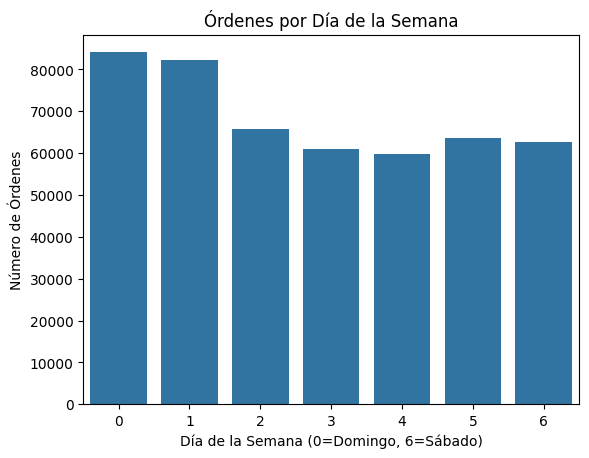

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def fetch_data(query):
    return pd.read_sql(query, conn)


orders = fetch_data("SELECT ORDER_DOW, COUNT(*) as total_orders FROM dim_orders GROUP BY ORDER_DOW ORDER BY ORDER_DOW")

sns.barplot(x=orders['ORDER_DOW'], y=orders['TOTAL_ORDERS'])
plt.xlabel('Día de la Semana (0=Domingo, 6=Sábado)')
plt.ylabel('Número de Órdenes')
plt.title('Órdenes por Día de la Semana')
plt.show()


# 2. Comportamiento de compra según hora del día

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


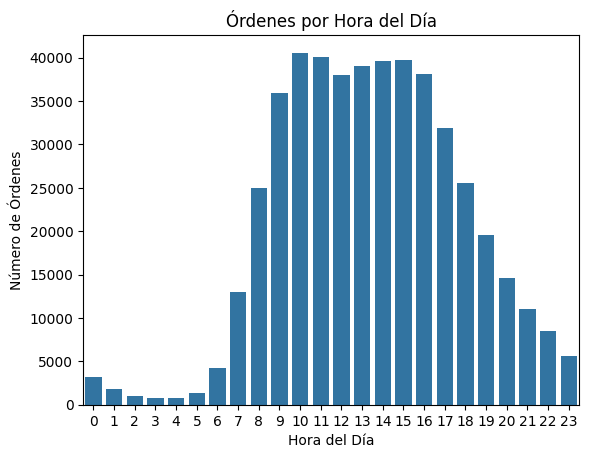

In [19]:


hours = fetch_data("SELECT order_hour_of_day, COUNT(*) as total_orders FROM dim_orders GROUP BY order_hour_of_day ORDER BY order_hour_of_day")

sns.barplot(x=hours['ORDER_HOUR_OF_DAY'], y=hours['TOTAL_ORDERS'])
plt.xlabel('Hora del Día')
plt.ylabel('Número de Órdenes')
plt.title('Órdenes por Hora del Día')
plt.show()



# 3. Comportamiento según hora del día y día de la semana

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


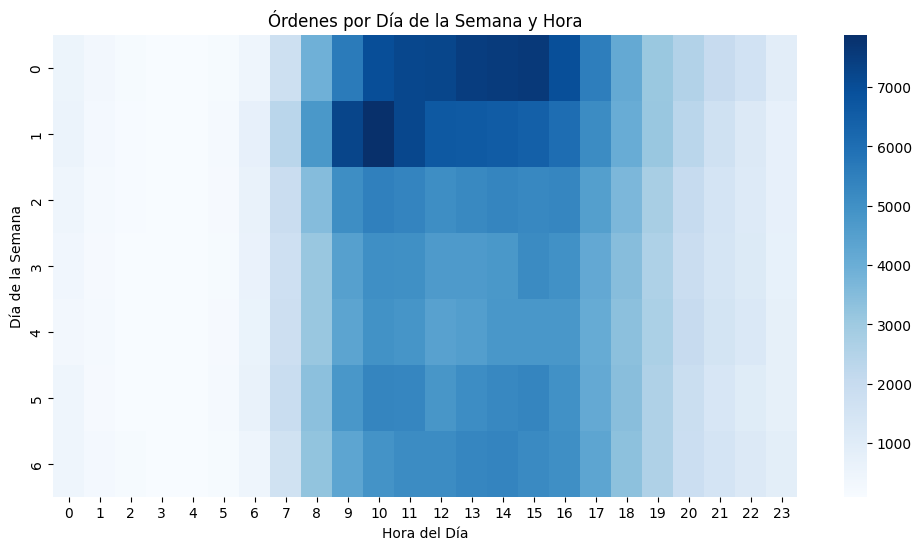

In [20]:

heatmap_data = fetch_data("""
    SELECT order_dow, order_hour_of_day, COUNT(*) as total_orders 
    FROM dim_orders 
    GROUP BY order_dow, order_hour_of_day
""")

# Asegurarse de que los nombres de columnas coincidan con el uso en pivot()
heatmap_pivot = heatmap_data.pivot(index="ORDER_DOW", columns="ORDER_HOUR_OF_DAY", values="TOTAL_ORDERS")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="Blues", annot=False)
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Órdenes por Día de la Semana y Hora')
plt.show()



# 4. Distribución de órdenes por cliente

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


Promedio de órdenes por usuario: 3.04


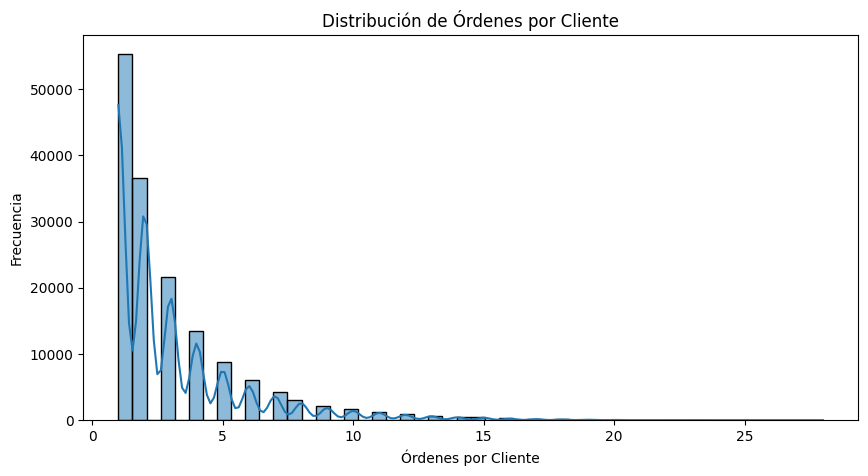

In [21]:

orders_per_user = fetch_data("SELECT user_id, COUNT(*) as total_orders FROM dim_orders GROUP BY user_id")
print(f"Promedio de órdenes por usuario: {orders_per_user['TOTAL_ORDERS'].mean():.2f}")

plt.figure(figsize=(10, 5))
sns.histplot(orders_per_user['TOTAL_ORDERS'], bins=50, kde=True)
plt.xlabel('Órdenes por Cliente')
plt.ylabel('Frecuencia')
plt.title('Distribución de Órdenes por Cliente')
plt.show()



# 5. Top 20 productos más frecuentes

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


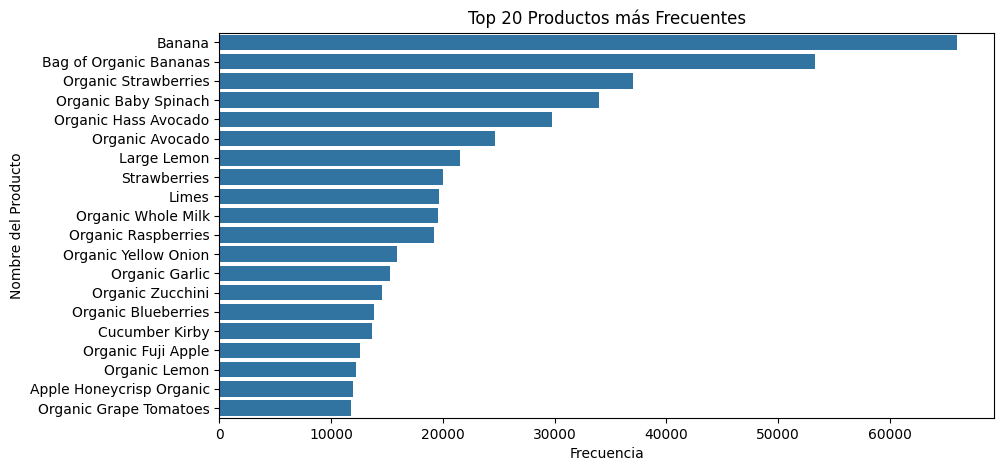

In [41]:
top_products = fetch_data("""
    SELECT p.product_name, COUNT(*) as frequency 
    FROM fact_orders o
    JOIN dim_products p ON o.product_id = p.product_id
    GROUP BY p.product_name
    ORDER BY frequency DESC
    LIMIT 20
""")

plt.figure(figsize=(10, 5))
sns.barplot(y=top_products['PRODUCT_NAME'], x=top_products['FREQUENCY'])
plt.xlabel('Frecuencia')
plt.ylabel('Nombre del Producto')
plt.title('Top 20 Productos más Frecuentes')
plt.show()


# 6. ¿Cuántos artículos se compran generalmente en un pedido?

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


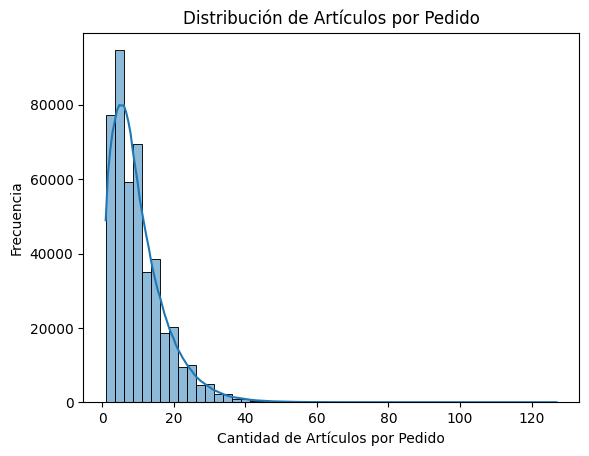

In [29]:
items_per_order = fetch_data("""
    SELECT order_id, COUNT(product_id) as total_items 
    FROM fact_orders 
    GROUP BY order_id
""")

sns.histplot(items_per_order['TOTAL_ITEMS'], bins=50, kde=True)
plt.xlabel('Cantidad de Artículos por Pedido')
plt.ylabel('Frecuencia')
plt.title('Distribución de Artículos por Pedido')
plt.show()


# 7. Top 20 artículos que se vuelven a pedir con más frecuencia

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


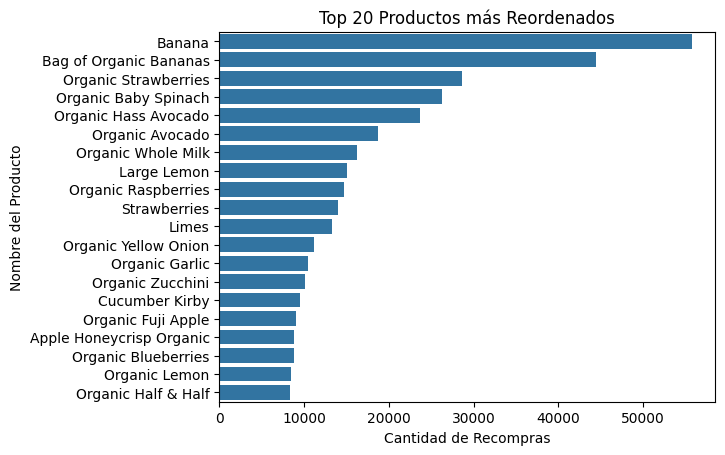

In [42]:
top_reordered_products = fetch_data("""
    SELECT p.product_name, COUNT(*) as reorder_count 
    FROM fact_orders o
    JOIN dim_products p ON o.product_id = p.product_id
    WHERE o.reordered = TRUE
    GROUP BY p.product_name
    ORDER BY reorder_count DESC
    LIMIT 20
""")

sns.barplot(y=top_reordered_products['PRODUCT_NAME'], x=top_reordered_products['REORDER_COUNT'])
plt.xlabel('Cantidad de Recompras')
plt.ylabel('Nombre del Producto')
plt.title('Top 20 Productos más Reordenados')
plt.show()



# 8. Proporción de pedidos que se vuelven a pedir para cada producto

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


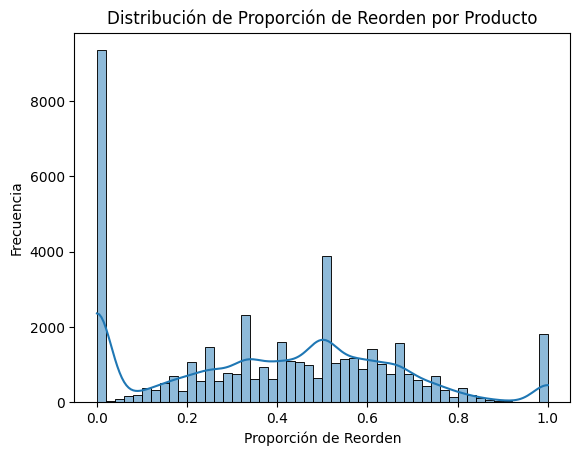

In [32]:
reorder_ratio = fetch_data("""
    SELECT product_id, 
           SUM(CASE WHEN reordered = TRUE THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS reorder_rate
    FROM fact_orders 
    GROUP BY product_id 
    ORDER BY reorder_rate DESC
""")

sns.histplot(reorder_ratio['REORDER_RATE'], bins=50, kde=True)
plt.xlabel('Proporción de Reorden')
plt.ylabel('Frecuencia')
plt.title('Distribución de Proporción de Reorden por Producto')
plt.show()


# 9. Proporción de productos pedidos que se vuelven a pedir para cada cliente

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


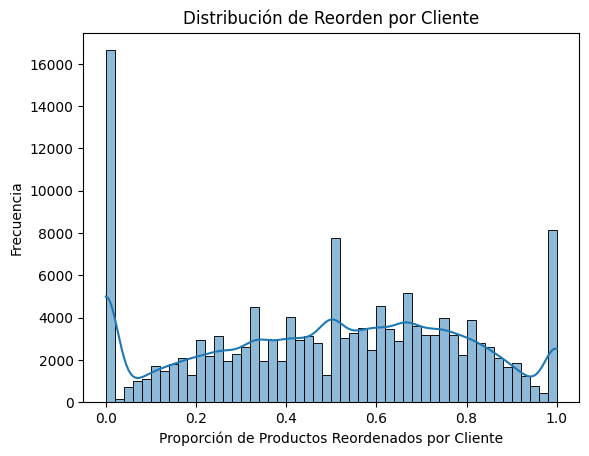

In [36]:
customer_reorder_ratio = fetch_data("""
SELECT o.user_id, 
       SUM(CASE WHEN f.reordered = TRUE THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS reorder_rate
FROM fact_orders f
JOIN dim_orders o ON f.order_id = o.order_id
GROUP BY o.user_id

""")

sns.histplot(customer_reorder_ratio['REORDER_RATE'], bins=50, kde=True)
plt.xlabel('Proporción de Productos Reordenados por Cliente')
plt.ylabel('Frecuencia')
plt.title('Distribución de Reorden por Cliente')
plt.show()

# 10. Top 20 artículos que la gente pone primero en el carrito

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_61893/1409348785.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


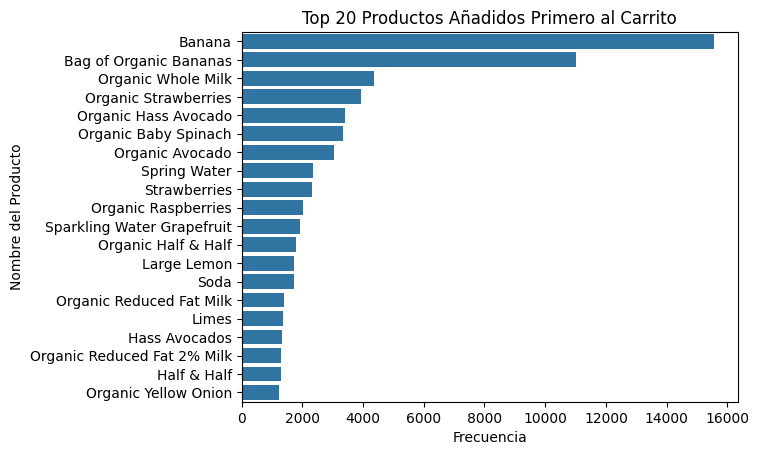

In [43]:
top_first_cart_products = fetch_data("""
    SELECT 
        p.product_name, 
        COUNT(*) AS first_cart_count 
    FROM fact_orders f
    JOIN dim_products p ON f.product_id = p.product_id
    WHERE f.orders = 1  
    GROUP BY p.product_name
    ORDER BY first_cart_count DESC 
    LIMIT 20;
""")

sns.barplot(y=top_first_cart_products['PRODUCT_NAME'], x=top_first_cart_products['FIRST_CART_COUNT'])
plt.xlabel('Frecuencia')
plt.ylabel('Nombre del Producto')
plt.title('Top 20 Productos Añadidos Primero al Carrito')
plt.show()
